In [19]:
import hopsworks
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np
from sklearn.metrics import mean_squared_error


In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [35]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query)

In [56]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

model = ensemble.RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_leaf=8,
                                         min_samples_split=2, n_estimators=200)


Finished: Reading data from Hopsworks, using Hive (2.62s) 


In [57]:
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(min_samples_leaf=8, n_estimators=200)

In [58]:
y_pred = model.predict(X_test)


# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=False, zero_division=1)
results = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           3       1.00      0.00      0.00         6
           4       1.00      0.00      0.00        38
           5       0.63      0.63      0.63       345
           6       0.55      0.74      0.63       480
           7       0.46      0.24      0.31       163
           8       1.00      0.00      0.00        33
           9       1.00      0.00      0.00         1

    accuracy                           0.57      1066
   macro avg       0.81      0.23      0.23      1066
weighted avg       0.60      0.57      0.54      1066



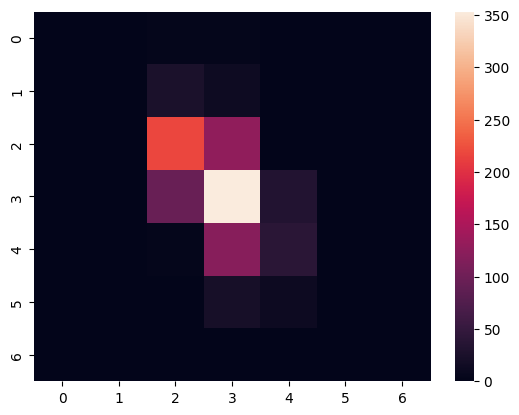

In [59]:
#Dålig på 5,6,7 - lika varandra? Var är 9?
print(metrics)

#df_cm = pd.DataFrame(results, ['True 3', 'True 4', 'True 5', 'True 6','True 7','True 8', 'True 9'],
#                     ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=False)
fig = cm.get_figure()

In [ ]:
mr = project.get_model_registry()


model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="iris_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Iris Flower Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)